In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import pearsonr


In [20]:
# MATCH BODY MOTION ENERGY TO NEURAL ACTIVITY FOR EACH CELL AND FRAME SESSION-WISE
#motion = pd.read_csv('/Volumes/Behaviour 3/S1_2P_Behaviour_AVIs_Body/body motion energy.csv', index_col=0)
# Read in body motion energy doen-sampled to 6 fps (see "2P Motion Energy Vectors" script)
motion = pd.read_csv('/Volumes/Behaviour 3/Bodyvectors_07_2000/body_motion_energy_07_2000.csv', index_col=0)

input_path = '/Volumes/Behaviour/Tailored 3sec 2P Trials' # dF_F0 traces cropped to 1.5 sec pre- and post-stimulus
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]

pearsons = pd.DataFrame()
session_names = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('CFA.csv'): # excluding for the time being CFA sessions
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    ses_name = entries[3]+'_'+entries[4][:5]
    session_names.append(ses_name)
    print(ses_name)
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    print('cells shape', cells.shape)
    cell_list = (list(cells.columns)) # list of rois 
    cell_list = cell_list[:-1] # last column is the identifier, hence I remove it
    session_mo = motion[motion['identifier'].str.contains(str(ses_name))] # subsetting body motion energy file to the session being processed
    print('session_mo shape', session_mo.shape)# subsetting body motion energy file to the session being processed
    session_mo['ids']  = session_mo.apply(lambda x: x['identifier'] +'_'+str(x['frame']), axis=1) # creating a new identifier column which combines trial ID and frame number
    # now I have to create a matching frames_for_each_trial column for the 2P recording dataframe
    frames_template = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]) # template with the number of frames per trial
    factor = int(cells.shape[0]/20) # finding out how many trials per session there are (this is not always identical to the motion energy file, due to the likelyhood threshold)
    cells['frame'] = np.tile(frames_template, factor) # distritbute 'frames_template' across the whole 2P recording
    cells['ids'] = cells.apply(lambda x: x['identifier'] +'_'+str(x['frame']), axis=1) # create new identifier column as in line 34
    temp = pd.merge(cells, session_mo, on="ids") # creating a temporary data frame by merging motion energy vectors and 2P traces aligned on 'ids' column  
    temp = temp.dropna()   # then dropping those frames that don't have motion energy values due to likelihood threshold                                
    
    # This was the inital approach creating a wide-format dataframe with one column per session
    #corr = []
    #for c in cell_list: # for each cell in a session, compute Pearsons' r by correlating with motion energy
        #P,_ = pearsonr(temp[c],temp['motion_e'])
    #corr = np.array(corr)
    #df = pd.DataFrame(corr, columns = [ses_name])

    #pearsons = pd.concat([pearsons, df], axis = 1)
    
    # This is the new approach creating a long-format dataframe with a combined cell+session identifier
    li = []
    for c in cell_list: # for each cell in a session, compute Pearsons' r by correlating with motion energy
        P,_ = pearsonr(temp[c],temp['motion_e'])
        li.append((c, P))
    
    corr = pd.DataFrame(li, columns=('cell_id', 'pearsons'))
    
    pearsons = pd.concat([pearsons, corr], axis = 0)

processing:  dF_F0_3sec_2P06_Ses01.csv
2P06_Ses01
cells shape (480, 359)
session_mo shape (380, 3)


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


processing:  dF_F0_3sec_2P06_Ses02.csv
2P06_Ses02
cells shape (460, 374)
session_mo shape (440, 3)
processing:  dF_F0_3sec_2P06_Ses03.csv
2P06_Ses03
cells shape (440, 284)
session_mo shape (440, 3)
processing:  dF_F0_3sec_2P05_Ses04.csv
2P05_Ses04
cells shape (480, 331)
session_mo shape (480, 3)
processing:  dF_F0_3sec_2P06_Ses04.csv
2P06_Ses04
cells shape (520, 365)
session_mo shape (460, 3)
processing:  dF_F0_3sec_2P06_Ses05.csv
2P06_Ses05
cells shape (480, 213)
session_mo shape (480, 3)
processing:  dF_F0_3sec_2P05_Ses06.csv
2P05_Ses06
cells shape (480, 320)
session_mo shape (480, 3)
processing:  dF_F0_3sec_2P06_Ses06.csv
2P06_Ses06
cells shape (480, 348)
session_mo shape (460, 3)
processing:  dF_F0_3sec_2P05_Ses07.csv
2P05_Ses07
cells shape (440, 377)
session_mo shape (440, 3)
processing:  dF_F0_3sec_2P06_Ses07.csv
2P06_Ses07
cells shape (460, 495)
session_mo shape (460, 3)
processing:  dF_F0_3sec_2P07_Ses01.csv
2P07_Ses01
cells shape (460, 305)
session_mo shape (440, 3)
processing

In [5]:
# To make plots off the wide-format data-frame
pearsons.reset_index(inplace=True)
pearsons = pearsons.rename(columns = {'index':'cell'})
ses = list(pearsons.columns)
ses = ses[1:]

output_path = '/Volumes/Behaviour/Tailored 3sec 2P Trials/Motion Correlation Plots'
ses = list(pearsons.columns[1:])
for s in ses:
    print(s)
    plt.figure(figsize=(10,5))
    plt.scatter(x=pearsons['cell'], y=pearsons[s], alpha = 0.5)
    plt.ylim((-0.2,0.5))
    plt.show()
    #plt.savefig(os.path.join(output_path, s+'_motion_correlation_04.png'))


cell_id


KeyboardInterrupt: 

In [33]:
pearsons.to_csv(os.path.join(output_path, 'pearsons_long_07_2000.csv'))
 #temp.to_csv(os.path.join(input_path, 'temp.csv'))

2P06_Ses01
2P06_Ses02
2P06_Ses03
2P05_Ses04
2P06_Ses04
2P06_Ses05
2P05_Ses06
2P06_Ses06
2P05_Ses07
2P06_Ses07
2P07_Ses01
2P08_Ses01
2P07_Ses03
2P08_Ses02
2P07_Ses04
2P08_Ses03
2P07_Ses05
2P08_Ses04
2P07_Ses06
2P08_Ses05
2P07_Ses07


/Users/aspra/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2P08_Ses06
2P09_Ses01
2P11_Ses01
2P10_Ses01
2P09_Ses02
2P10_Ses02
2P09_Ses04
2P11_Ses04
2P11_Ses05
2P11_Ses02
2P09_Ses03
2P10_Ses03
2P10_Ses04
2P09_Ses05
2P10_Ses05
2P11_Ses06
2P05_Ses03


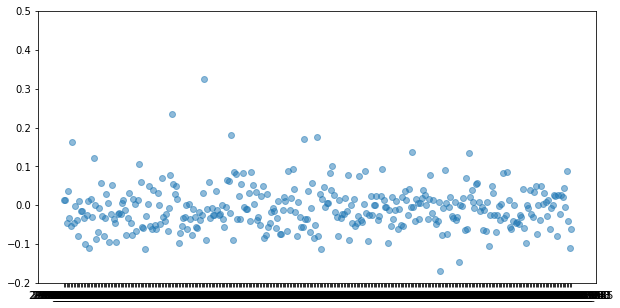

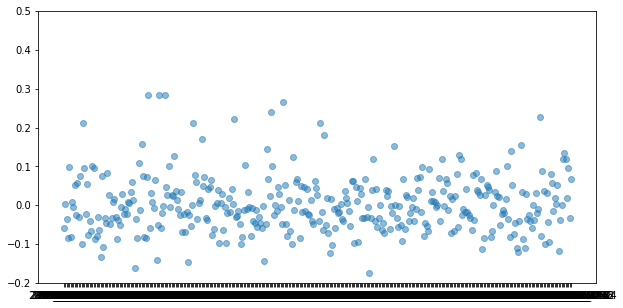

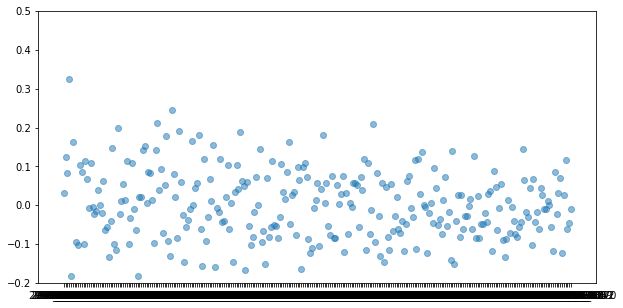

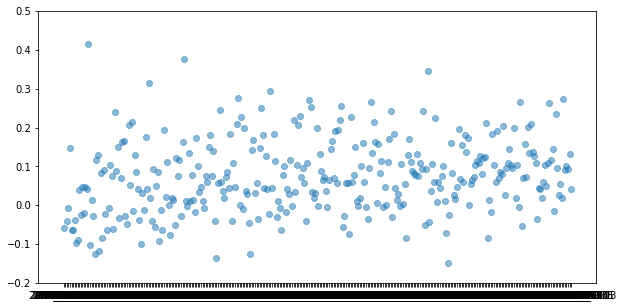

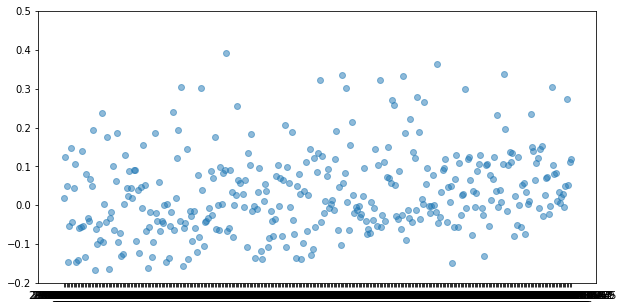

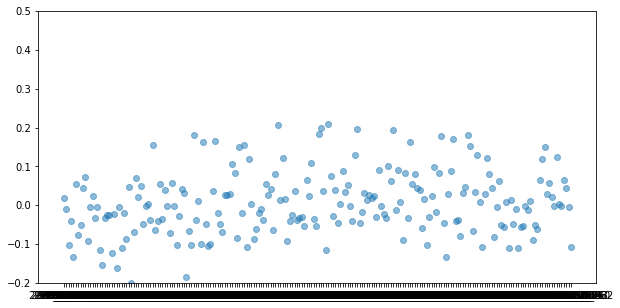

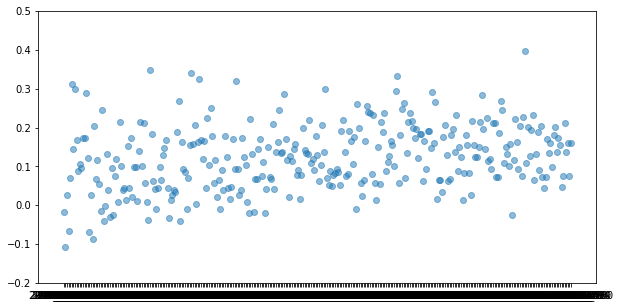

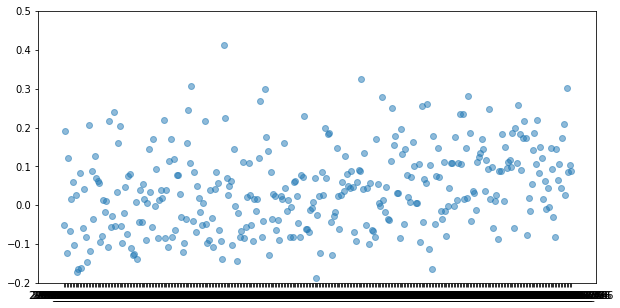

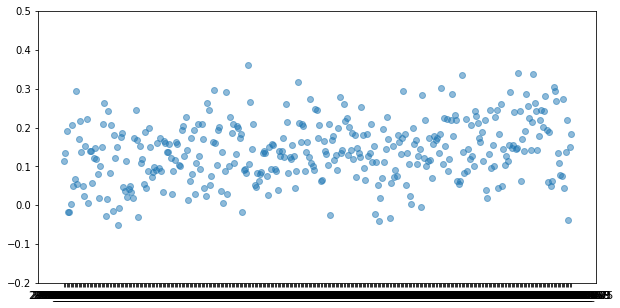

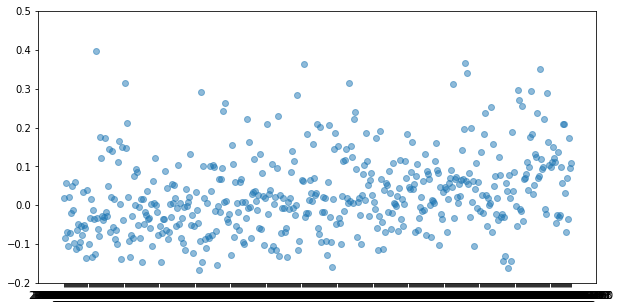

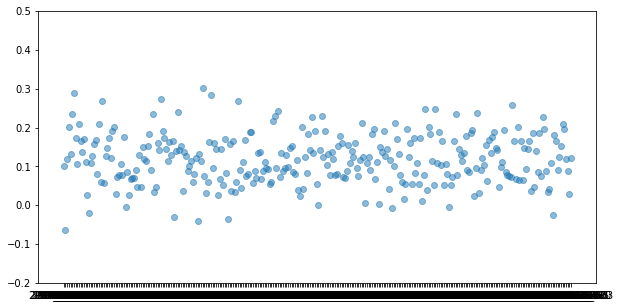

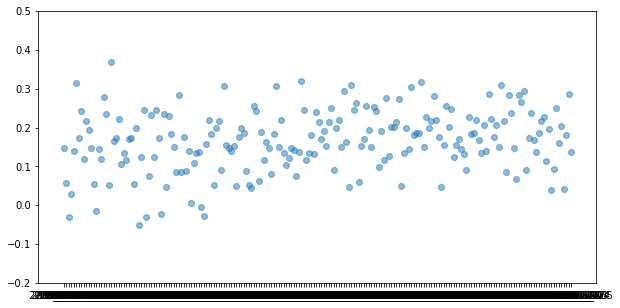

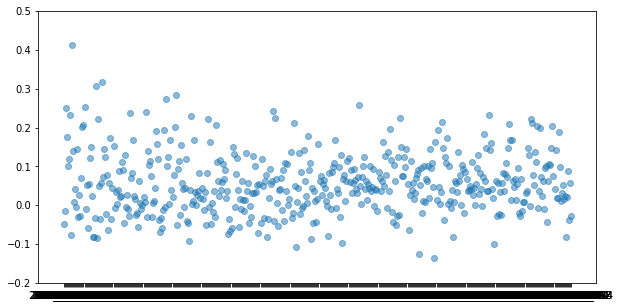

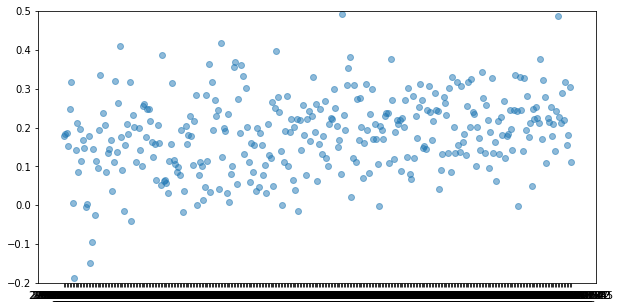

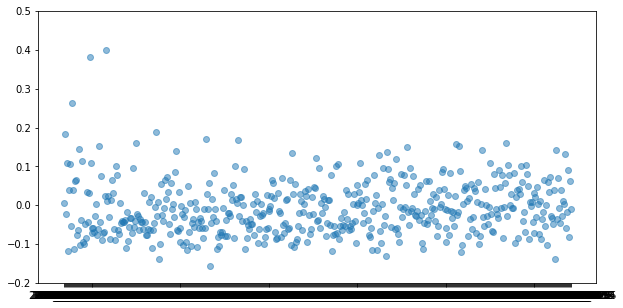

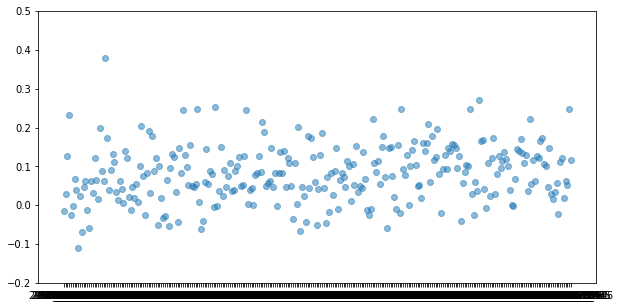

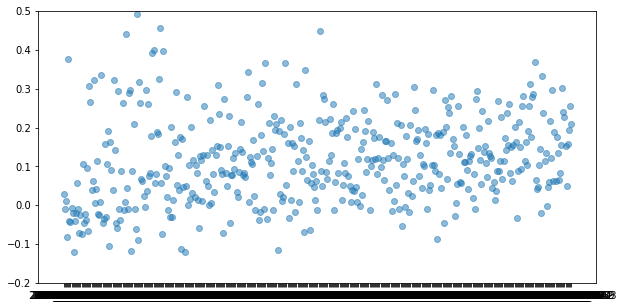

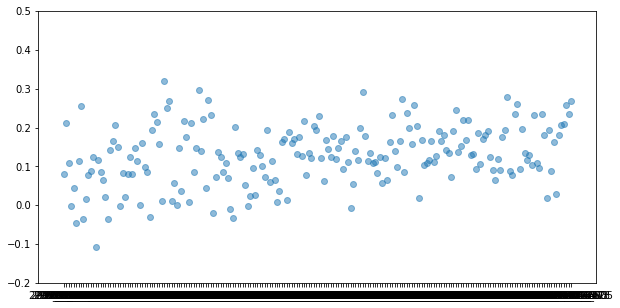

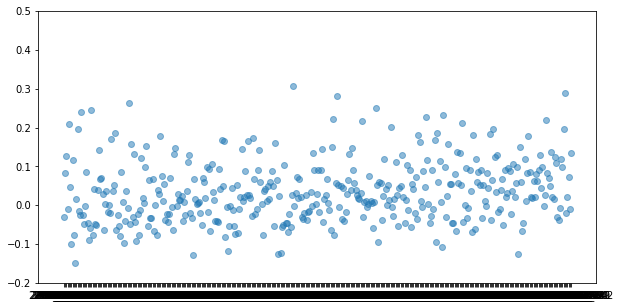

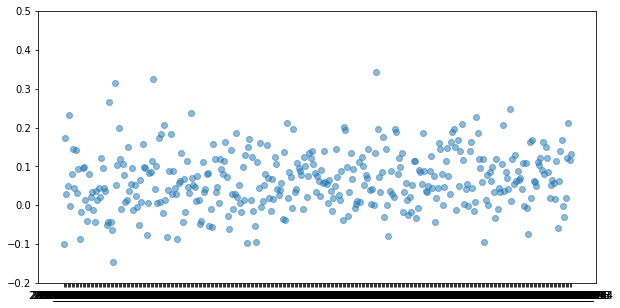

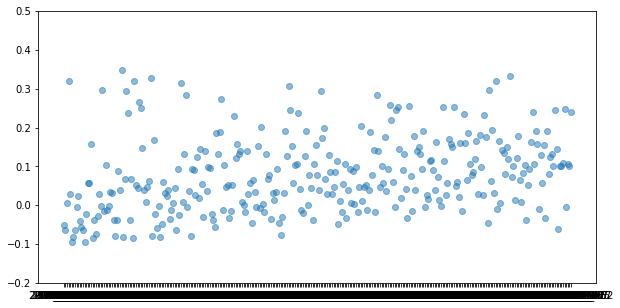

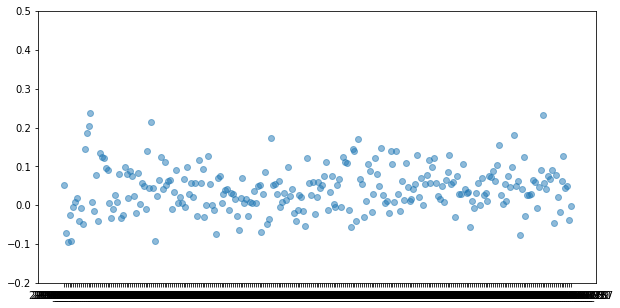

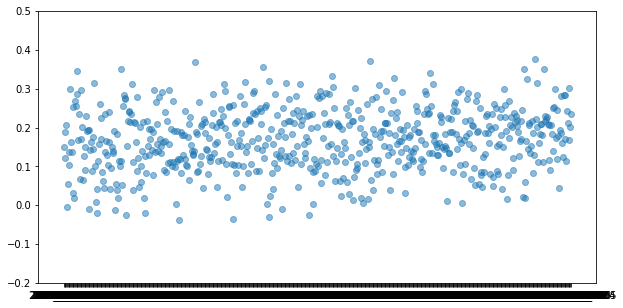

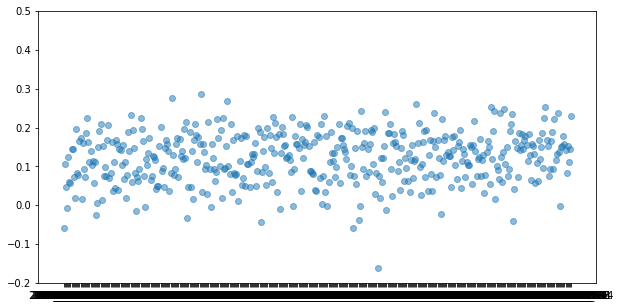

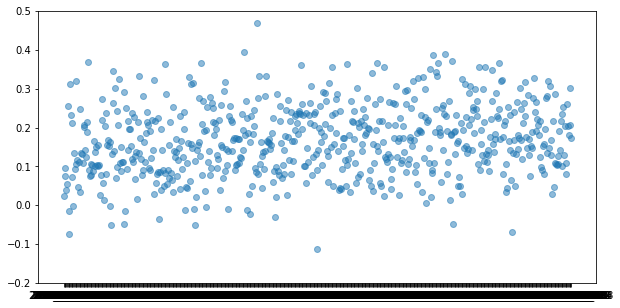

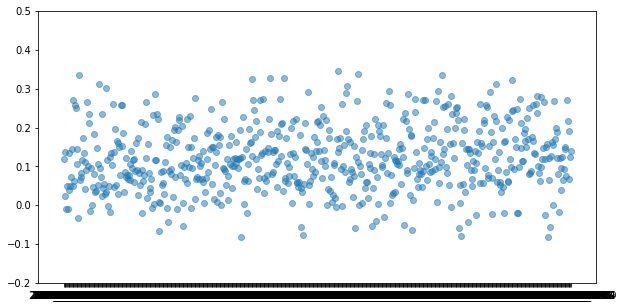

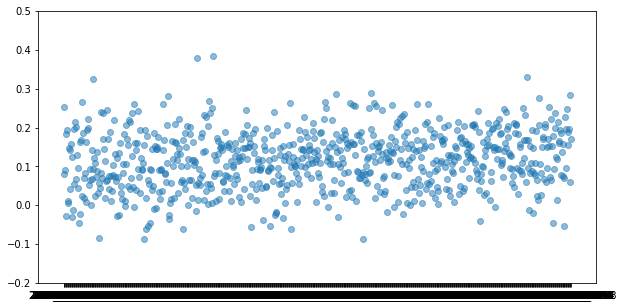

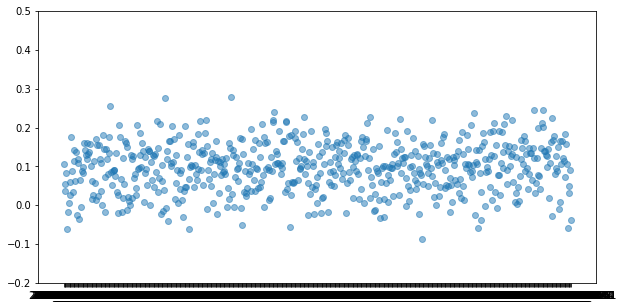

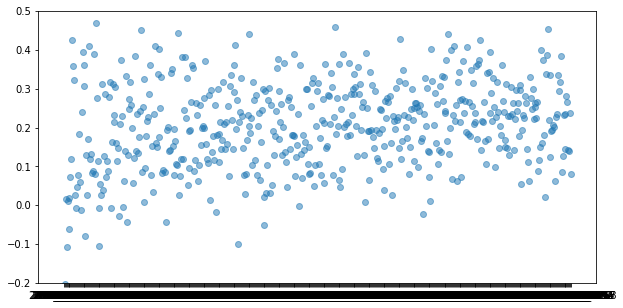

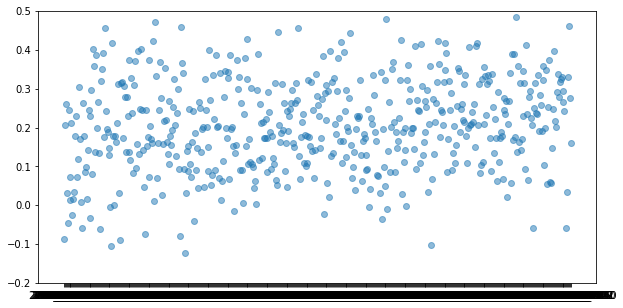

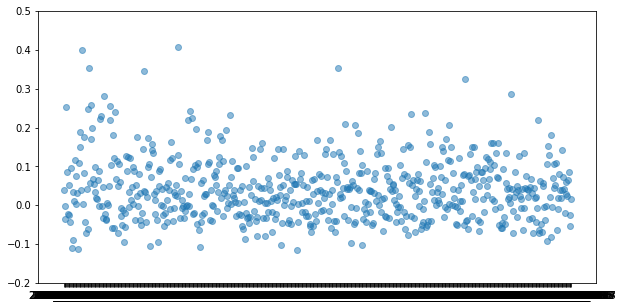

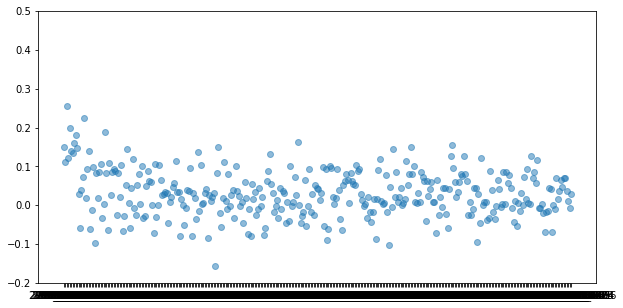

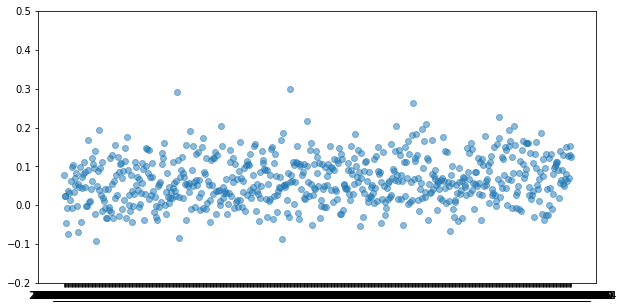

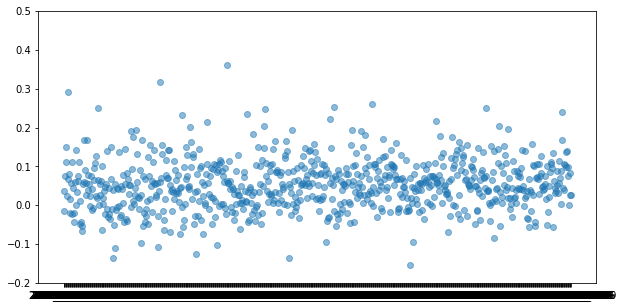

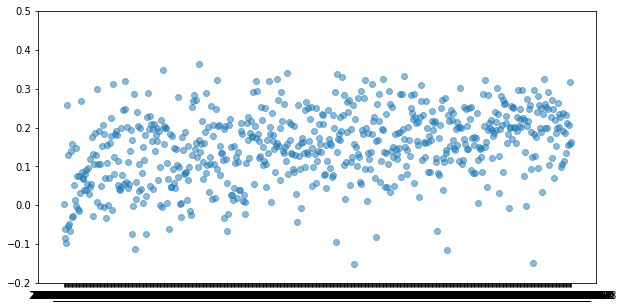

Error in callback <function flush_figures at 0x1171d1378> (for post_execute):


KeyboardInterrupt: 

In [30]:
# To make plots off the long-format data-frame
output_path = '/Volumes/Behaviour/Tailored 3sec 2P Trials/Motion Correlation Plots'

for s in session_names:
    print(s)
    df = pearsons[pearsons['cell_id'].str.contains(str(s))]
    plt.figure(figsize=(10,5))
    plt.scatter(x=df['cell_id'], y=df['pearsons'], alpha = 0.5)
    plt.ylim((-0.2,0.5))
    #plt.show()
    plt.savefig(os.path.join(output_path, s+'_motion_correlation_07.png'))



2P06_Ses01


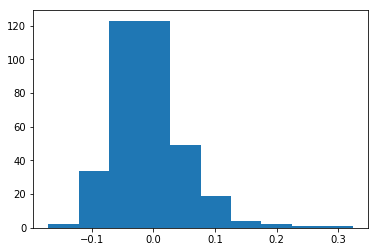

2P06_Ses02


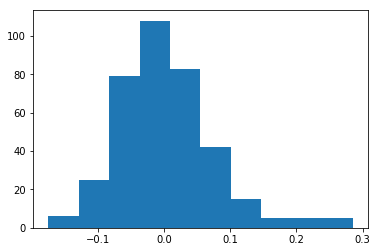

2P06_Ses03


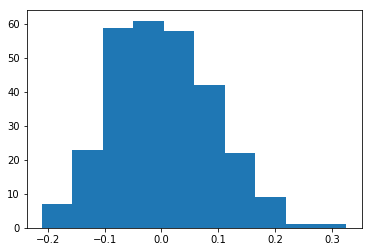

2P05_Ses04


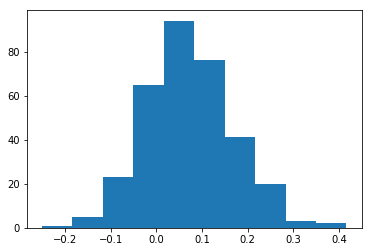

2P06_Ses04


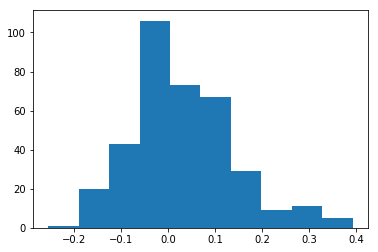

2P06_Ses05


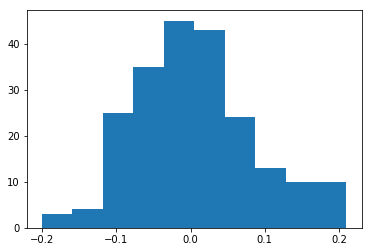

2P05_Ses06


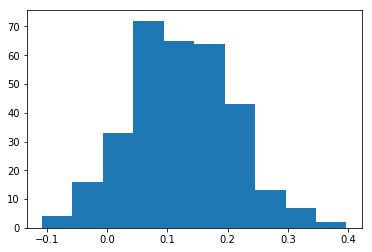

2P06_Ses06


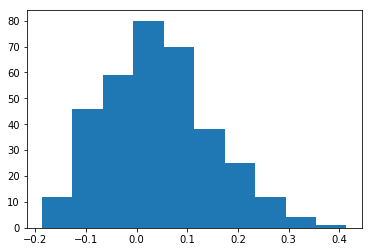

2P05_Ses07


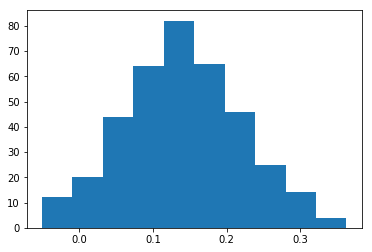

2P06_Ses07


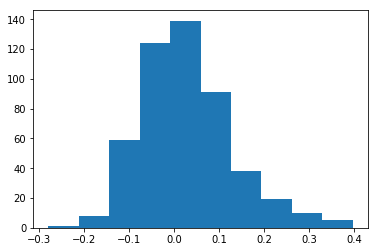

2P07_Ses01


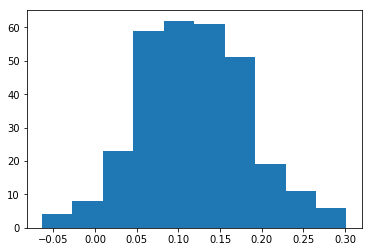

2P08_Ses01


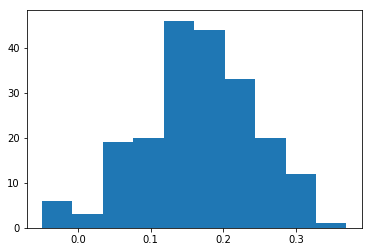

2P07_Ses03


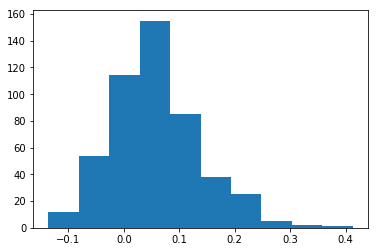

2P08_Ses02


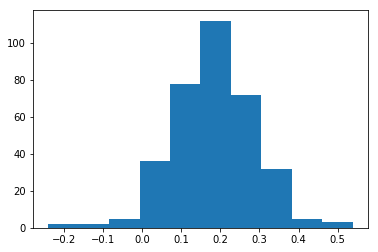

2P07_Ses04


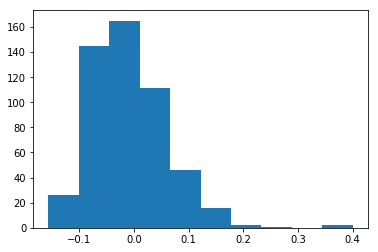

2P08_Ses03


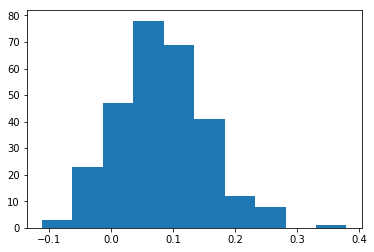

2P07_Ses05


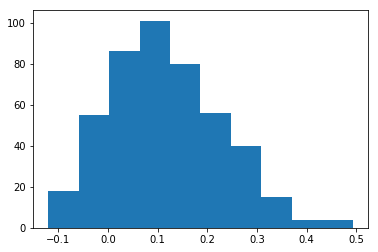

2P08_Ses04


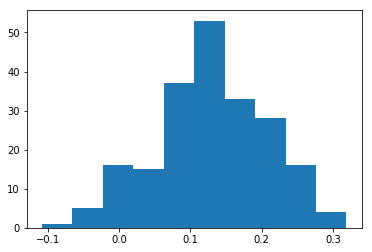

2P07_Ses06


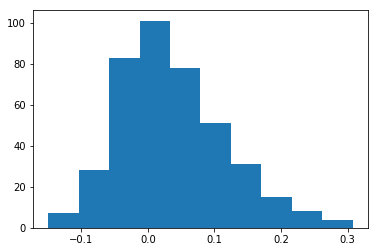

2P08_Ses05


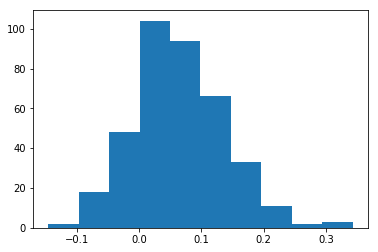

2P07_Ses07


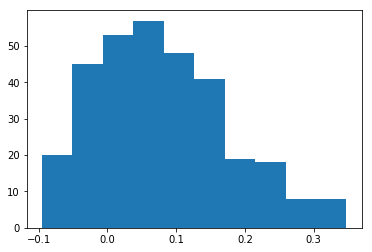

2P08_Ses06


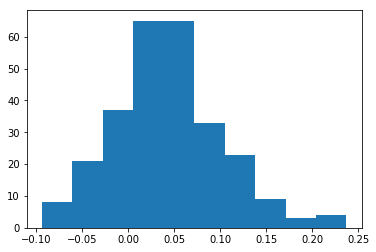

2P09_Ses01


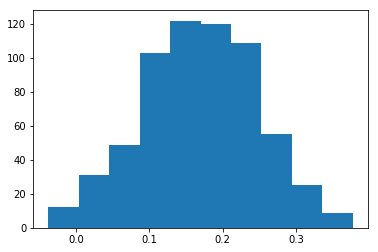

2P11_Ses01


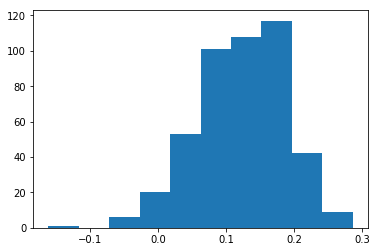

2P10_Ses01


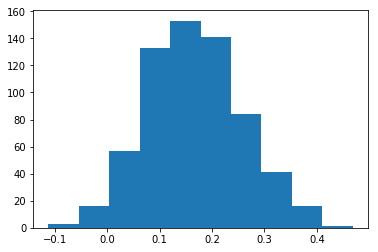

2P09_Ses02


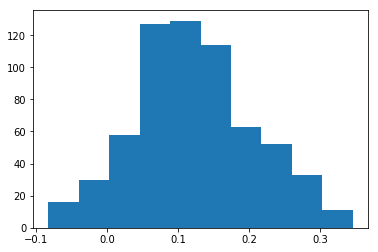

2P10_Ses02


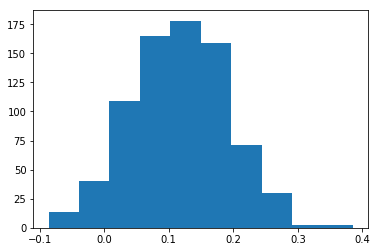

2P09_Ses04


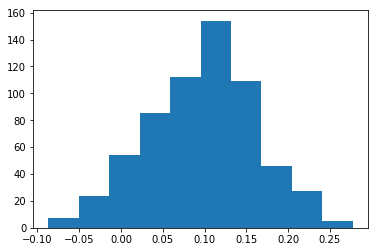

2P11_Ses04


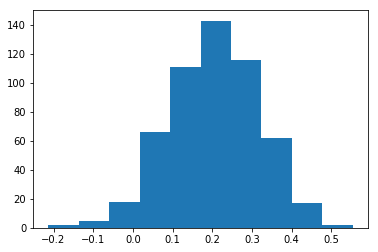

2P11_Ses05


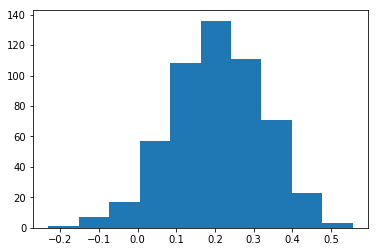

2P11_Ses02


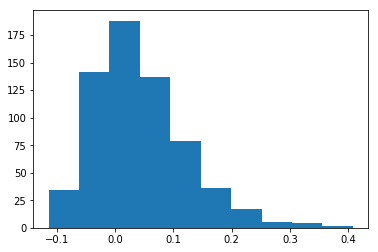

2P09_Ses03


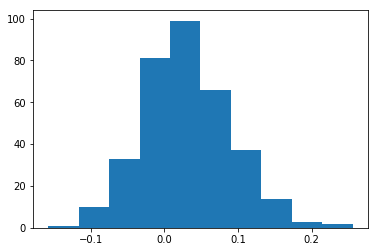

2P10_Ses03


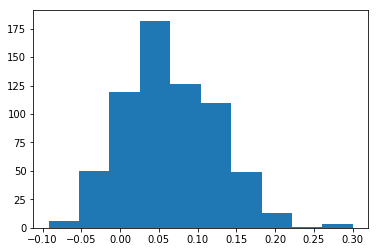

2P10_Ses04


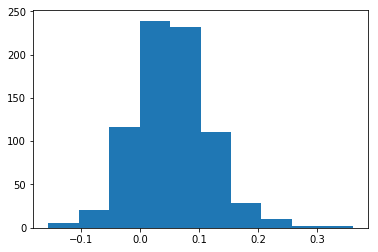

2P09_Ses05


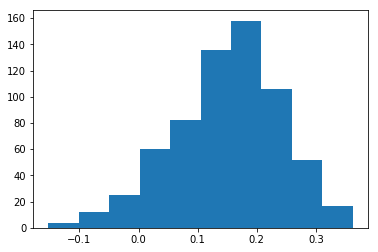

2P10_Ses05


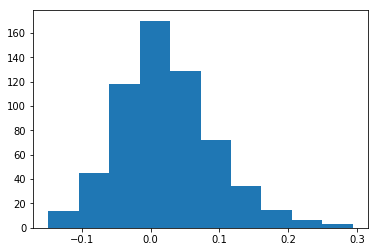

2P11_Ses06


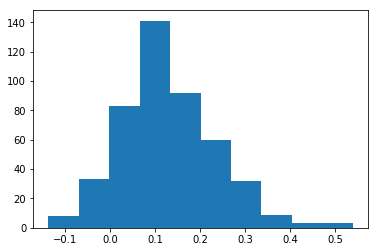

2P05_Ses03


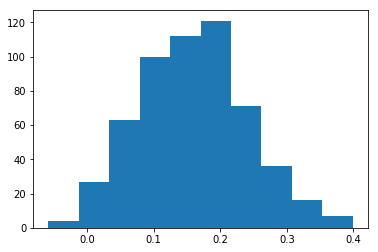

<Figure size 432x288 with 0 Axes>

In [32]:
# To make histograms off the long-format data-frame
output_path = '/Volumes/Behaviour/Tailored 3sec 2P Trials/Motion Correlation Histograms'

for s in session_names:
    print(s)
    df = pearsons[pearsons['cell_id'].str.contains(str(s))]
    plt.hist(df['pearsons'])
    plt.show()
    plt.savefig(os.path.join(output_path, s+'_motion_correlation_distributino_07.png'))
    

In [25]:
s = '2P11_Ses06'
df = pearsons[pearsons['cell_id'].str.contains(str(s))]
df

,cell_id,pearsons
0,2P11_Ses06_0,-0.077402
1,2P11_Ses06_1,0.010021
2,2P11_Ses06_2,0.054222
3,2P11_Ses06_4,-0.019154
4,2P11_Ses06_5,0.023131
...,...,...
459,2P11_Ses06_1053,0.175433
460,2P11_Ses06_1082,0.211432
461,2P11_Ses06_1089,0.000210
462,2P11_Ses06_1118,0.230339
